# Employee Retention #

In [1]:
import pandas as pd
from datetime import timedelta, date
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import mean_squared_error

from IPython.display import Image  
import pydotplus

import matplotlib.pyplot as plt
%matplotlib inline

## Exploratory Data Analysis ##

Some preliminary summary stats to have an overview of the data.

In [2]:
df = pd.read_csv('employee_retention_data.csv')

In [3]:
def cat_col_summary(df, catogorical_cols):
    for val in catogorical_cols:
        print('total counts: ', df[val].count())
        print(df[val].value_counts())
        print('-'*40)

# print out a summary of the dataframe
def df_summary(df, catogorical_cols):
    print('dim of table:')
    print(df.shape, '\n')
    
    print('first few rows of the table:')
    print('='*40)
    print(df.head(), '\n')
    
    print('count of null values:')
    print('='*40)
    print(df.isnull().sum(), '\n')
    
    print('summary of numeric values')
    print('='*40)
    print(df.describe(), '\n')
    
    print('\nsummary of categorical values')
    print('='*40)
    cat_col_summary(df, catogorical_cols)

In [4]:
discrete_vals = ['dept']
df_summary(df, discrete_vals)

dim of table:
(24702, 7) 

first few rows of the table:
   employee_id  company_id              dept  seniority    salary   join_date  \
0      13021.0           7  customer_service         28   89000.0  2014-03-24   
1     825355.0           7         marketing         20  183000.0  2013-04-29   
2     927315.0           4         marketing         14  101000.0  2014-10-13   
3     662910.0           7  customer_service         20  115000.0  2012-05-14   
4     256971.0           2      data_science         23  276000.0  2011-10-17   

    quit_date  
0  2015-10-30  
1  2014-04-04  
2         NaN  
3  2013-06-07  
4  2014-08-22   

count of null values:
employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64 

summary of numeric values
         employee_id    company_id     seniority         salary
count   24702.000000  24702.000000  24702.000000   24702.000000
mean   501604.403530 

2 employees have work experience of ~100 years, likely a data entry error, thereby removing from the table.

In [5]:
print(df['seniority'].value_counts(bins=[0, 20, 30, 40, 80, 150], sort=False))
print(df[df['seniority']>80])

# removing the 2 erroneous entries with 'seniority' level greater than 80
df = df[df['seniority']<=80]

0     18364
20     6336
30        0
40        0
80        2
Name: seniority, dtype: int64
       employee_id  company_id       dept  seniority    salary   join_date  \
24700      97289.0          10   engineer         98  266000.0  2011-12-13   
24701     604052.0           1  marketing         99  185000.0  2011-07-26   

        quit_date  
24700  2015-01-09  
24701  2013-12-06  


Plot join and quit count against date to see if there's any trends against time.

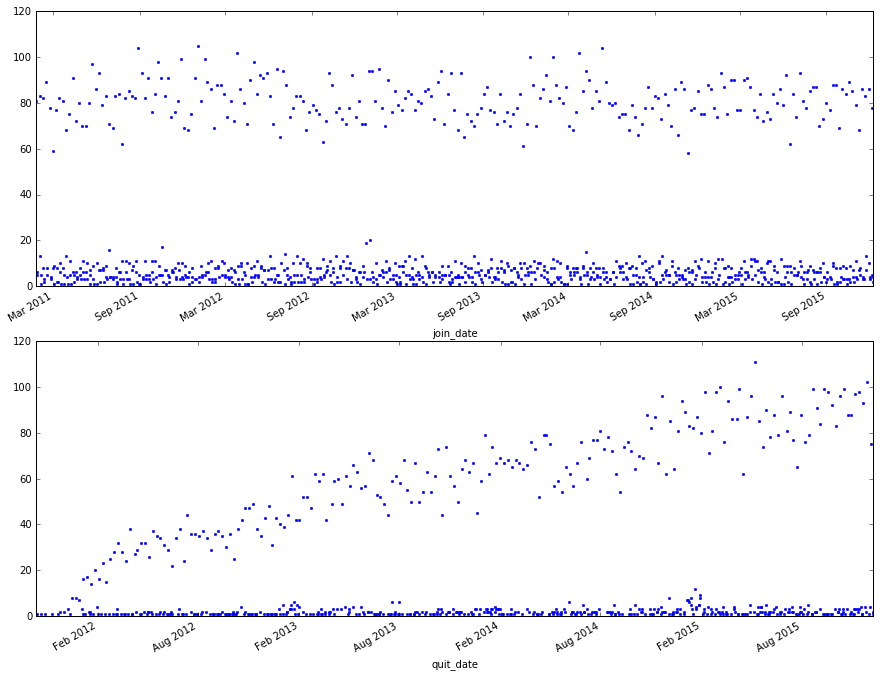

In [6]:
# convert date variables to the proper data type
df['join_date'] = pd.to_datetime(df['join_date'])
df['quit_date'] = pd.to_datetime(df['quit_date'])

# plot to see if there are join and quit trends against time
fig, ax = plt.subplots(figsize=(15, 12))
plt.subplot(211)
join_window = (df['join_date']>='2011-01-24')&(df['join_date']<'2015-12-31')
df[join_window].groupby('join_date')['join_date'].count().plot(marker='.', ms='5', ls='None')

plt.subplot(212)
quit_window = (df['quit_date']>='2011-01-24')&(df['quit_date']<'2015-12-31')
df[quit_window].groupby('quit_date')['quit_date'].count().plot(marker='.', ms='5', ls='None')
plt.show()

The data centers around 2 values for joining rate - on some days the total join count centers around 80 and on the rest days they center around 10, and they seem to be alternating with a weekly pattern. Similarly for quit rate, we see a steady increase of the count from 0 to around 80, while on the rest of the days there are very few number of people who quit, and the days seem to be alternating with a weekly pattern as well.  


***

## Number of Employees by Company Per Day ##

Now we calculate the number of employees for each company every day.

In [7]:
# helper function to generate range of dates given start and end date
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

# given a single date, return the number of employees of each company on that day
def get_counts_per_day(df, current_date):
    window_join = (df['join_date']<= current_date)
    window_quit = (df['quit_date']<= current_date)
    
    # get the count of joins and quits up to that date
    join_grouped = df[window_join].groupby('company_id')['join_date'].count()
    quit_grouped = df[window_quit].groupby('company_id')['quit_date'].count()
    
    # count = No. of joins - No. of quits
    current_count = join_grouped - quit_grouped
    
    # return a dataframe of the date, company index and the number of 
    # employees of the corresponding company 
    n = len(current_count)
    current_count_l = list(current_count)
    result = [(current_date, current_count.index[i], current_count_l[i]) for i in range(n)]
    return pd.DataFrame(result)

# example
current_date = '2015-08-25'
get_counts_per_day(df, current_date)

,0,1,2
0,2015-08-25,1,3844
1,2015-08-25,2,2006
2,2015-08-25,3,1225
3,2015-08-25,4,917
4,2015-08-25,5,787
5,2015-08-25,6,572
6,2015-08-25,7,532
7,2015-08-25,8,476
8,2015-08-25,9,435
9,2015-08-25,10,392


company_id
1     Axes(0.125,0.125;0.775x0.775)
2     Axes(0.125,0.125;0.775x0.775)
3     Axes(0.125,0.125;0.775x0.775)
4     Axes(0.125,0.125;0.775x0.775)
5     Axes(0.125,0.125;0.775x0.775)
6     Axes(0.125,0.125;0.775x0.775)
7     Axes(0.125,0.125;0.775x0.775)
8     Axes(0.125,0.125;0.775x0.775)
9     Axes(0.125,0.125;0.775x0.775)
10    Axes(0.125,0.125;0.775x0.775)
11    Axes(0.125,0.125;0.775x0.775)
12    Axes(0.125,0.125;0.775x0.775)
Name: employee_headcount, dtype: object

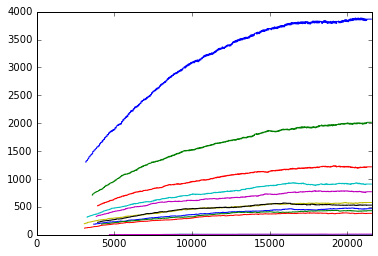

In [8]:
# calculate the employee counts for all dates
start_date, end_date = date(2011, 1, 24), date(2016, 1, 1)

employee_headcounts = pd.DataFrame()
for single_date in daterange(start_date, end_date):
    current_date = single_date.strftime("%Y-%m-%d")
    current_date_count = get_counts_per_day(df, current_date)
    employee_headcounts = pd.concat([employee_headcounts, current_date_count])

employee_headcounts.reset_index(drop=True, inplace=True)
employee_headcounts.columns = ['day', 'company_id', 'employee_headcount']

# a simple visualization to show the change of the employee counts overtime
employee_headcounts.groupby('company_id')['employee_headcount'].plot()

In [9]:
df['quit_date'][0].weekday()

4

***

## Employee Retention Analysis ##

Now we look into the main driver behind employee churn. Let's start by calculating the length of employment.

In [10]:
# employment length = quit date - join date in days
df['employment_length'] = df['quit_date'] - df['join_date']
df_terminated = df.dropna().copy() # drop NA (when an employee has not quit as of the end of the data)
df_terminated['employment_length'] = df_terminated['employment_length'].apply(lambda x: x.days)

# examine the data
df_terminated.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30,578


Simple plots showing how the length of the employment varies with different variables.

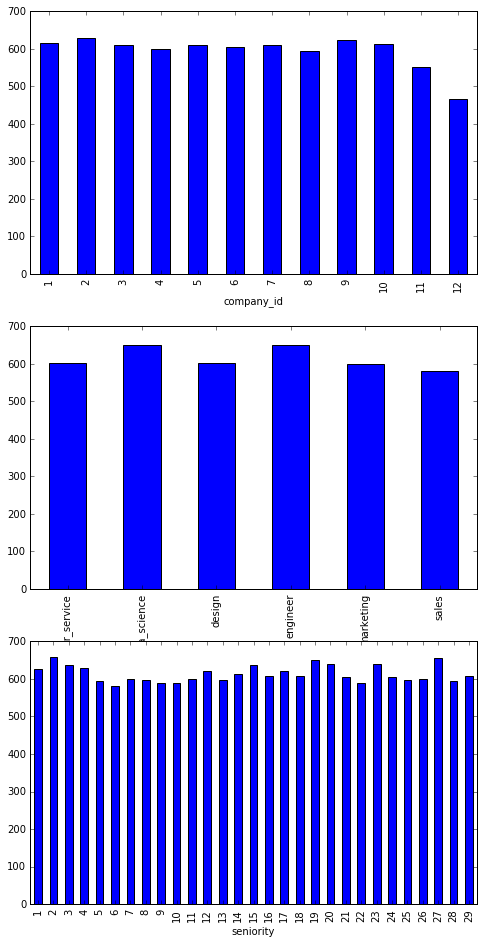

In [11]:
# plots of average employment length by company, department and seniority
columns = list(df_terminated.columns)[1:4]
n, i = len(columns), 0
fig, ax = plt.subplots(figsize=(8, 16))

for column in columns:
    i += 1
    plt.subplot(n, 1, i)
    df_terminated.groupby(column)['employment_length'].mean().plot(kind='bar')
    
plt.show()

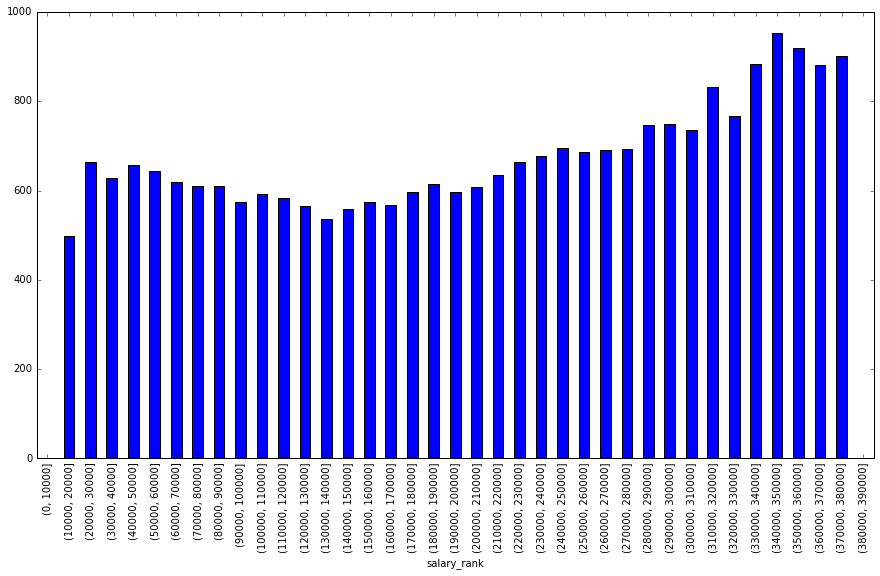

In [12]:
# plot of average employment length by salary
fig, ax = plt.subplots(figsize=(15, 8))
df_terminated['salary_rank'] = pd.cut(df_terminated['salary'], list(range(0, 400000, 10000)))
df_terminated.groupby('salary_rank')['employment_length'].mean().plot(kind='bar')

A couple observations:  
* While we see variations in plots by department and seniority, differences are relatively small and there doesn't seem to be noticeable trends or outliers
* Company 11 and 12 have noticeably lower average employment length than the rest 10 companies - something worth investigating
* the average length of employment by salary displays a v-shaped trend. It decreases as people's salaries increase to around 130,000 and then starts going back up again as the salaries continue to increase. It looks like people earning medium level salaries (80,000 - 160,000) are mostly likely to quit early


Let's now take a look at the employment length by join and quit year for any unusual trends.

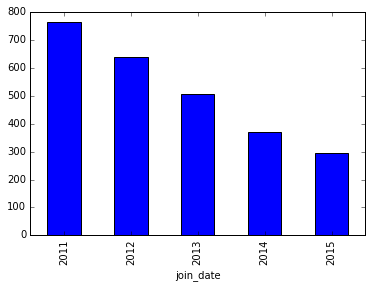

In [13]:
# plot of average employment length by year of joining
df_terminated.groupby(df_terminated['join_date'].apply(lambda x: x.year))['employment_length'].mean().plot(kind='bar')

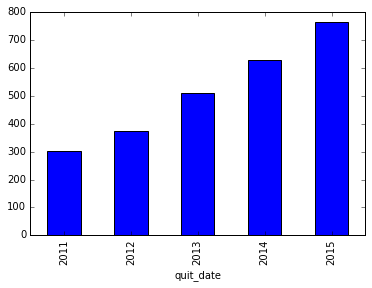

In [14]:
# plot of average employment length by year of quiting
df_terminated.groupby(df_terminated['quit_date'].apply(lambda x: x.year))['employment_length'].mean().plot(kind='bar')

The average length of employment decreases as join dates get later and increases as quit dates get later. This all makes sense, because people who join at a later time point and quit before 2015-12-31 will have a shorter average length of employment, and people who quit at a later time point will have a longer average length of employment. We didn't see any disruption in the trends here so people's quiting is unlikely to be driven by which year it is.  

*** 

### Investigation on Company Influence ###

Now we look into potential reasons for company 11 and 12 having a considerably shorter average length of employment. After breaking down the data further, it seems that on average company 11 and 12 pay their employees at a relatively low rate, which seems consistent with the story of the salary plot.

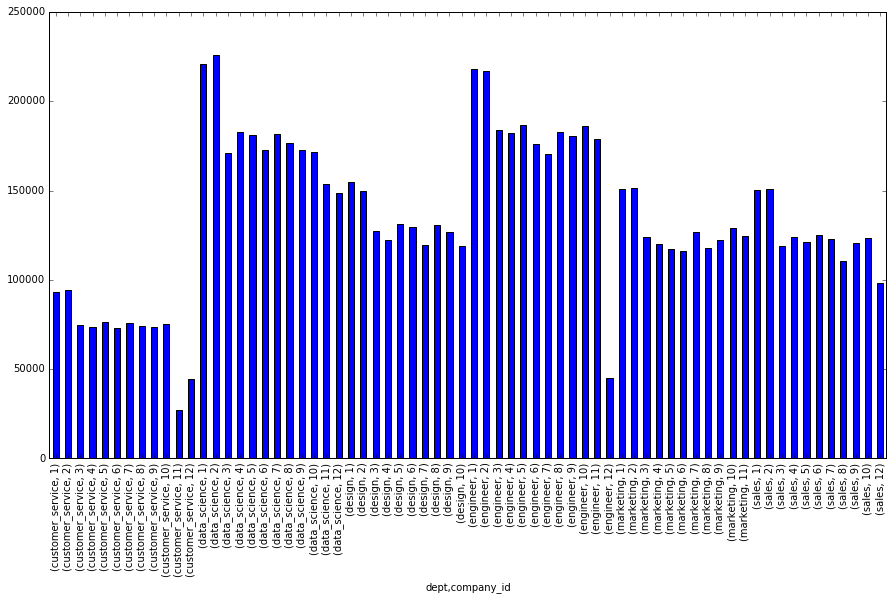

In [15]:
# tabular display
# pd.set_option("display.max_rows",999)
# df_terminated.groupby(['dept', 'company_id'])['salary'].mean()
# pd.reset_option("display.max_rows")

# bar plot display
fig, ax = plt.subplots(figsize=(15, 8))
df_terminated.groupby(['dept', 'company_id'])['salary'].mean().plot(kind='bar')

*** 

### Regression by Decision Tree ###

We now use decision tree regressor to find out the driver behind employment length.

In [16]:
# clean up the dataframe and encode categorical dept column into 0-1 columns of length(No. unique values for dept)
depts = list(df_terminated['dept'].value_counts().index)

def featurize(row):
    v = [row['dept'] == i for i in depts]
    return pd.Series(v)

df_depts = df_terminated.apply(featurize, axis=1).astype(int)
df_depts.columns = depts
df_new = pd.concat([df_terminated, df_depts], axis=1)
df_new = df_new.drop(['dept', 'salary_rank'], axis=1)

In [17]:
# randomization of the dataframe
# not needed as we are using train-test-split by sklearn which automatically does this for us
# np.random.seed(192837)
# df_shuffled = df_new.iloc[np.random.permutation(len(df_new))]
# df_shuffled.reset_index(drop=True, inplace=True)

# for the feature set, keep only company, seniority, salary and dept 
# since other variables should not have an impact on the length of employment
# (we didn't see any unusual trends for join and quit date in our earlier exploration)
X_features = df_new.drop(['employee_id','employment_length', 'join_date', 'quit_date'], axis=1)
y = df_new['employment_length']
X_features.head()

,company_id,seniority,salary,customer_service,engineer,sales,marketing,data_science,design
0,7,28,89000.0,1,0,0,0,0,0
1,7,20,183000.0,0,0,0,1,0,0
3,7,20,115000.0,1,0,0,0,0,0
4,2,23,276000.0,0,0,0,0,1,0
5,4,14,165000.0,0,0,0,0,1,0


In [18]:
# create predictor values (X: input) and classification result (y: output) arrays
X_train, X_holdout, y_train, y_holdout = train_test_split(X_features, y, test_size=0.25, random_state=424242)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=123456)

In [19]:
# regression by decision tree
clf = tree.DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_holdout)
clf.feature_importances_ 

array([ 0.02267348,  0.01455184,  0.96277468,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

From the feature importance array we see the salary variable dominates the prediction, followed by little influence from the seniority and zero influence from company and dept variables. If we increase the max depth of the tree, we will see changes in the values of the feature importances. The dominating feature, however, remains to be the salary.  

We now plot the tree to find out the exact cutoff point in the salary.

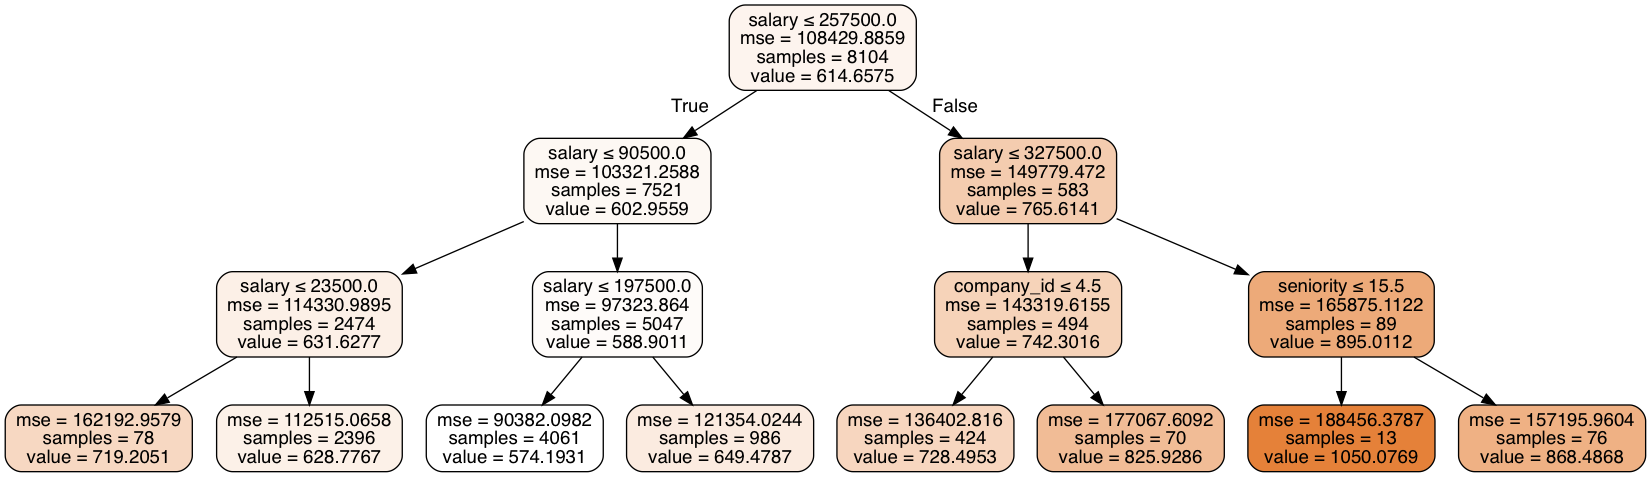

In [20]:
# tree visualization
feature_names = list(X_train.columns)
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_names,
                                class_names=['not converted', 'converted'],
                                filled=True, rounded=True, special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [21]:
# checking the MSE of the prediction
# although this is of limited usefulness as we don't have a threshold to compare against
mean_squared_error(y_holdout, y_pred)

105774.92685113612

***

## Conclusions ##

> 1. Given how important is salary, I would definitely love to have as a variable the salary the employee who quit was offered in the next job. Otherwise, things like: promotions or raises received during the employee tenure would be interesting.
> 2. The major findings are that employees quit at year anniversaries or at the beginning of the year. Both cases make sense. Even if you don’t like your current job, you often stay for 1 yr before quitting + you often get stocks after 1 yr so it makes sense to wait. Also, the beginning of the year is well known to be the best time to change job: companies are hiring more and you often want to stay until end of Dec to get the calendar year bonus.
> 3. Employees with low and high salaries are less likely to quit. Probably because employees with high salaries are happy there and employees with low salaries are not that marketable, so they have a hard time finding a new job.

> Another good exploratory analysis to do is see the count of employees for each employment length. People might get bored in the same place for too long. In general, whenever you have a date, extract week of the year, and day of the week. They tend to give an idea of seasonlity and weekly trends.

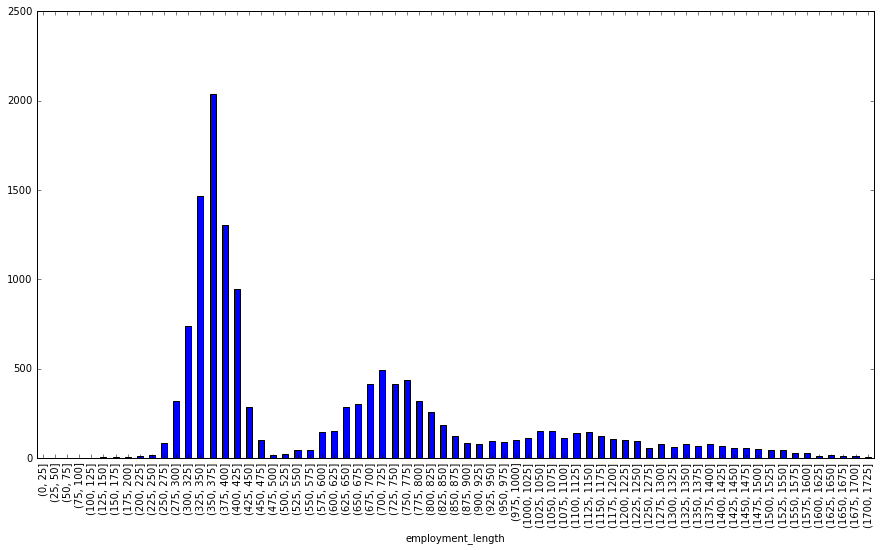

In [22]:
max_length = df_terminated['employment_length'].max()
fig, ax = plt.subplots(figsize=(15, 8))
length_segments = pd.cut(df_terminated['employment_length'], range(0, max_length, 25))
df_terminated.groupby(length_segments)['employee_id'].count().plot(kind='bar')

> Very interesting, there are peaks around each employee year anniversary!  

> Let's plot week of the year. Here the guide suggested that the count also peaks around the new year (which I am not seeing here)  
¯\\_(ツ)_/¯

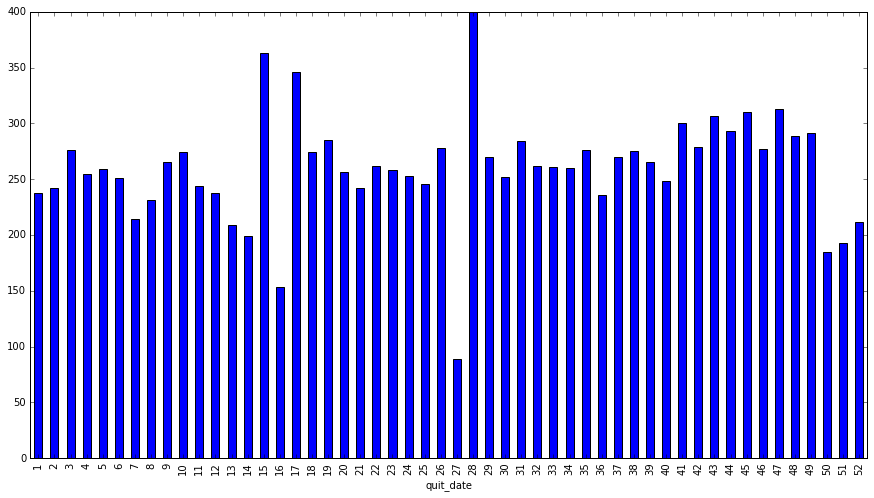

In [23]:
fig, ax = plt.subplots(figsize=(15, 8))
df_terminated.groupby(df_terminated['quit_date'].apply(lambda x: x.weekofyear))['employee_id'].count().plot(kind='bar')

Another thing the guide suggested is to only look at early quiters, which is a valuable segmentation technique. I'd think we should look into both segments to see if they have different drivers. 

In [24]:
# checking early quitters
df_early_quitters = df_new[df_new['employment_length'] <= 365]
X_early_quitters = df_early_quitters.drop(['employee_id','employment_length', 'join_date', 'quit_date'], axis=1)
y_early_quitters = df_early_quitters['employment_length']

# regression by decision tree
clf = tree.DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
clf = clf.fit(X_early_quitters, y_early_quitters)

clf.feature_importances_ 

array([ 0.05492012,  0.        ,  0.81865026,  0.        ,  0.        ,
        0.        ,  0.        ,  0.12642962,  0.        ])

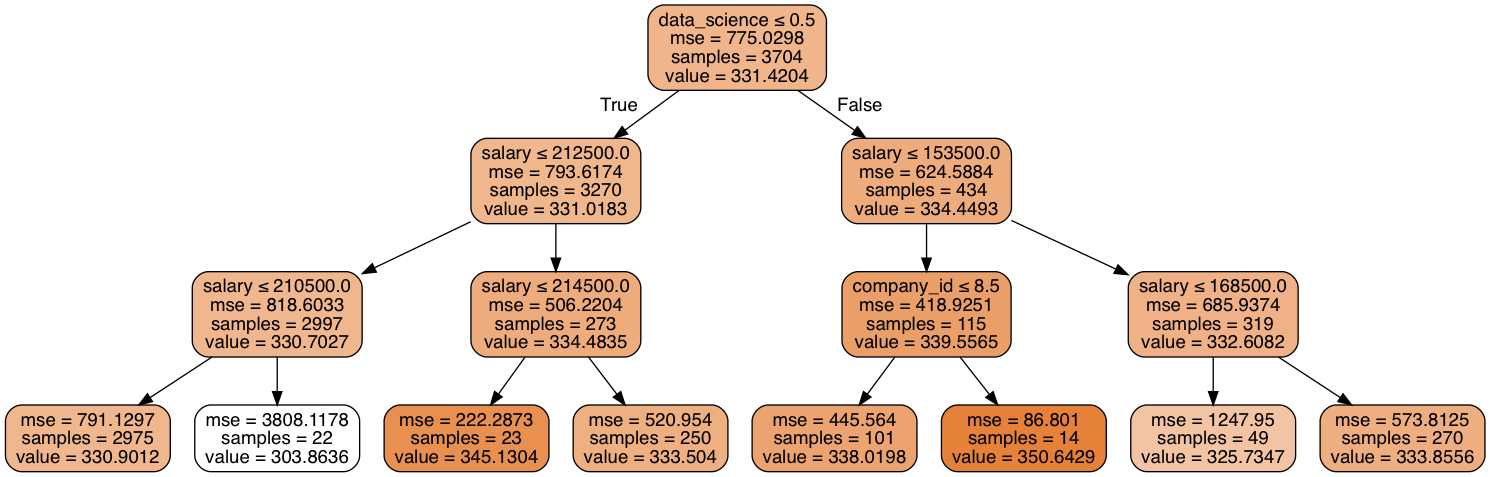

In [25]:
# tree visualization
feature_names = list(X_features.columns)
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_names,
                                class_names=['not converted', 'converted'],
                                filled=True, rounded=True, special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [26]:
# checking regular
df_regular = df_new[df_new['employment_length'] > 365]
X_regular = df_regular.drop(['employee_id','employment_length', 'join_date', 'quit_date'], axis=1)
y_regular = df_regular['employment_length']

# regression by decision tree
clf = tree.DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
clf = clf.fit(X_regular, y_regular)

clf.feature_importances_ 

array([ 0.00979735,  0.        ,  0.99020265,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

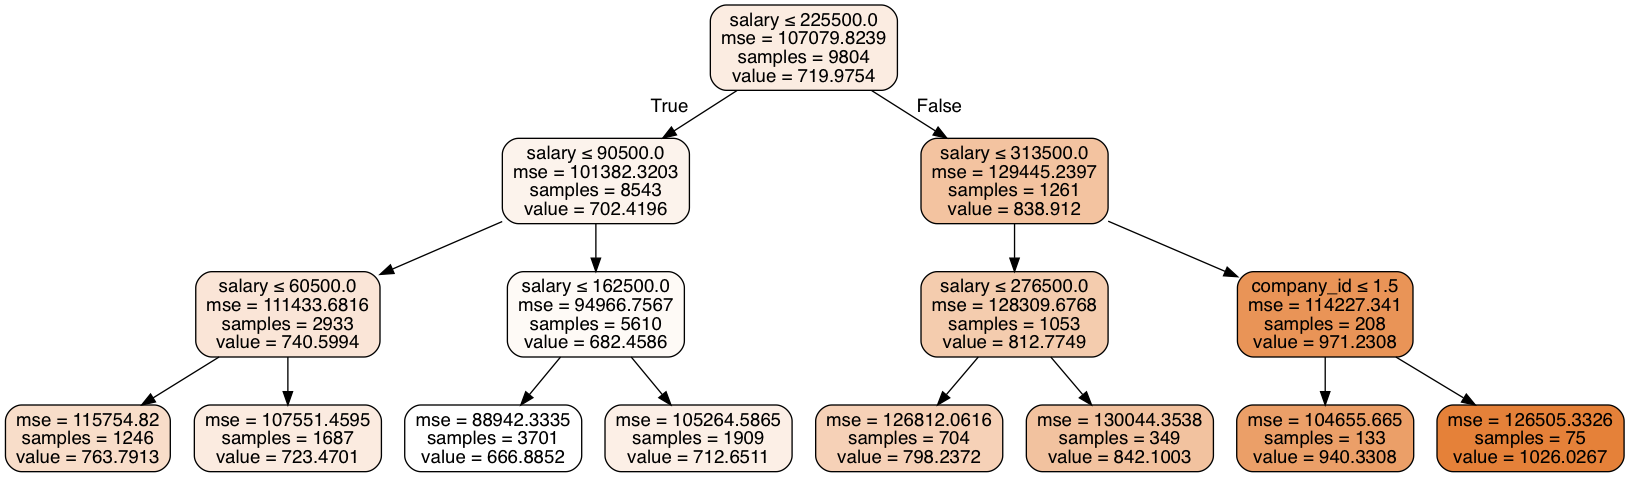

In [27]:
# tree visualization
feature_names = list(X_features.columns)
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=feature_names,
                                class_names=['not converted', 'converted'],
                                filled=True, rounded=True, special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())